# Polynomial Regression: The Bias-Variance Tradeoff

In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2

**Add the `src` directory as one where we can import modules**

In [2]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src'))
sys.path.append(src_dir)
print(src_dir)

C:\Users\josi\Documents\workshop-data-science\src


## The machine learning model development process

<img src="./_img/ML_scheme.png", style="height: 600px;">

**Import libraries**

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper_funcs as hf

**Load `train_test_split`, `one_step_learning`, `predict` and `rmse` functions we defined in the previous notebook**

In [4]:
from modelling_functions import *

In [5]:
!cat ../src/modelling_functions.py

## selected functions 

import numpy as np
import pandas as pd

def train_test_split(df, ratio=0.3, rs=42):
    np.random.seed(rs)
    idx = np.random.choice([True, False], size=df.shape[0], 
                           replace=True, p=[1-ratio, ratio])
    train = df.loc[idx,:]
    test = df.loc[~idx,:]
    print("Train set: {}".format(train.shape))
    print("Test set: {}".format(test.shape))
    return train, test

def one_step_learning(X, y):
    return np.dot( np.dot ( np.linalg.inv ( np.dot(X.T, X) ), X.T), y )

def predict(X, beta):
    return np.dot(X, beta)

def rmse(y_hat, y):
    return np.sqrt(np.sum((y_hat-y)**2)/len(y))


## Data preparation

In this example the data is generated from a function that is unknown to you. At the end of this segment we uncover the secret of the data generation process.


In [6]:
data = hf.data_generator(60, rs=400)

We have a bunch of data points, each data point is a $(x,y)$ pair.

In [7]:
data.sample(6)

,x,y
19,0.969513,0.554376
24,0.191468,0.636870
50,0.207393,0.509127
27,0.102375,0.324562
40,0.393976,0.650383
38,0.767504,-1.056180


Here is the data in form of a scatter plot:

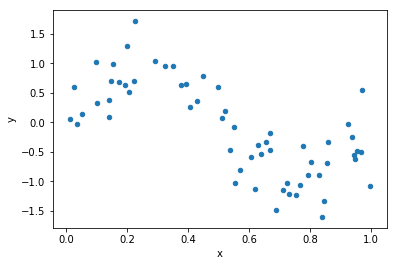

In [8]:
data.plot.scatter(x="x", y="y");

## Train-Validation Split

In [9]:
train, val = train_test_split(data, ratio=0.2, rs=44) 
X_train = train.x.values.reshape(-1,1)
y_train = train.y.values
X_val = val.x.values.reshape(-1,1)
y_val = val.y.values

Train set: (45, 2)
Test set: (15, 2)


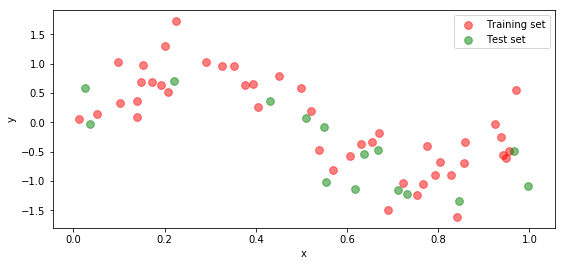

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
train.plot.scatter(x="x", y="y", ax=ax, 
                   alpha=0.5, s=60, color="r", label="Training set")
val.plot.scatter(x="x", y="y", ax=ax, 
                  alpha=0.5, s=60, color="g", label="Test set");

## Learning Algorithm

[Polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression) is a special type of linear regression in which the relationship between the predictor variable $x$ and the response variable $y$ is modeled by a k<sup>th</sup>-degree polynomial in $x$. The incorporation of k<sup>th</sup>-degree polynomials results in a nonlinear relation between $y$ and $x$, but between the parameters $(\beta_i)$ and the expected observations is linear. The model equation can be written as 

$$\hat y = \beta_0+\beta_1x+\beta_2x^2+...+\beta_kx^k+\epsilon$$

Finding the optimal parameter combination is done by minimizing the **sum of squared errors (SSE)**, given by the equation

$$SSE = \sum e^2 = \sum (\hat y - y)^2 $$

By fitting a polynomial to observations there arises the problem of choosing the order $k$ of the polynomial. How to choose the right number for the polynomial is a matter of an important concept called **model comparison** or [**model selection**](https://en.wikipedia.org/wiki/Model_selection). To keep it simple we use the [**root-mean-square error  (RMSE)**](https://en.wikipedia.org/wiki/Root-mean-square_deviation) defined by

$$RMSE = \sqrt{\frac{\sum_{i=1}^n (\hat y - y)^2}{n}}$$

to evaluate the goodness-of-fit of the model. 


#### Hyperparamter: Generate polynomial and interaction features (Feature engineering).


$$\text{e.g. 2nd order:} \qquad (x,y) \to (x,y,x^2, xy,y^2)$$ 



Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

The `scikit-learn` library provides powerful functionality to create polynomial features.

In [11]:
from sklearn.preprocessing import PolynomialFeatures
poly2d = PolynomialFeatures(degree=2, 
                            interaction_only=False, 
                            include_bias=False)

In [12]:
M = np.array([[1,10], 
             [2,20],
             [3,30]])
M

array([[ 1, 10],
       [ 2, 20],
       [ 3, 30]])

In [13]:
poly2d.fit_transform(M)

array([[  1.,  10.,   1.,  10., 100.],
       [  2.,  20.,   4.,  40., 400.],
       [  3.,  30.,   9.,  90., 900.]])

Now that we know how to create polynomial features, we 

* build 6 different models, with $k = 1,2,3,5,9,14$. For each model we 

* calculate the RMSE on the training set and on the validation. 

* Finally, we plot the data together with the regression line, given by each particular model. For convenience we construct a loop to reduce the amount of coding.

In [14]:
def build_polynomial_model(X_train, y_train, X_val, y_val, degree):
    from sklearn.preprocessing import PolynomialFeatures
    
    ### create polynomial features ###
    poly = PolynomialFeatures(degree)
    poly.fit(X_train)
    # polynomials for the train set
    X_train_poly = poly.transform(X_train)
    # polynomials for the validation set
    X_val_poly = poly.transform(X_val)
    # polynomials for the regression line
    X_predict_reg_line = poly.transform(np.linspace(0,1, 100).reshape(-1,1))
        
    ### learn paramters ###
    beta = one_step_learning(X_train_poly, y_train)
        
    ### create regression line ###
    y_predict_reg_line = predict(X_predict_reg_line, beta)

    ### predict on training set ###
    y_train_predict = predict(X_train_poly, beta)
    ## RMSE on training set
    rmse_train = rmse(y_train_predict, y_train)

    ### predict validation set ###
    y_val_predict = predict(X_val_poly, beta)
    ## RMSE on validation set
    rmse_val = rmse(y_val_predict, y_val)

    return rmse_train, rmse_val, y_predict_reg_line


In [15]:
def visualize_polynomial_model(train, val,
                               x_regline, y_regline, 
                               rmse_train, rmse_val,
                               degree, ax):
    
    train.plot.scatter(x="x", y="y", ax=ax, 
                   alpha=0.5, s=60, color="r", label="Training set")
    val.plot.scatter(x="x", y="y", ax=ax, 
                      alpha=0.5, s=60, color="g", label="Validation set")
    ax.legend(loc="lower left")
    ax.plot(x_regline, y_regline)
    ax.text(s=r"$RMSE_T:$ {}".format(np.round(rmse_train,3)), 
            x=0.75, y=1.15, size=16)
    ax.text(s=r"$RMSE_V:$ {}".format(np.round(rmse_val,3)), 
            x=0.75,y=0.85, size=16)
    ax.set_ylim(-1.95,1.95)
    ax.set_title("Polynomial Regression (degree: {})".format(degree), 
                 size=18);    


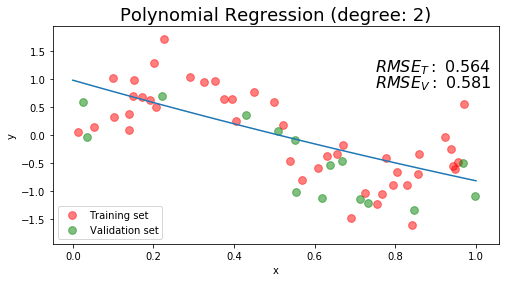

In [26]:
(rmse_train, 
 rmse_val, 
 y_predict_reg_line) = build_polynomial_model(X_train,
                                              y_train, 
                                              X_val,
                                              y_val,
                                              degree=2)

fix, ax = plt.subplots(figsize=(8,4))
visualize_polynomial_model(train=train, val=val, 
                           x_regline=np.linspace(0,1, 100),
                           y_regline=y_predict_reg_line,
                           rmse_train=rmse_train, rmse_val=rmse_val,
                           degree=2, ax=ax)

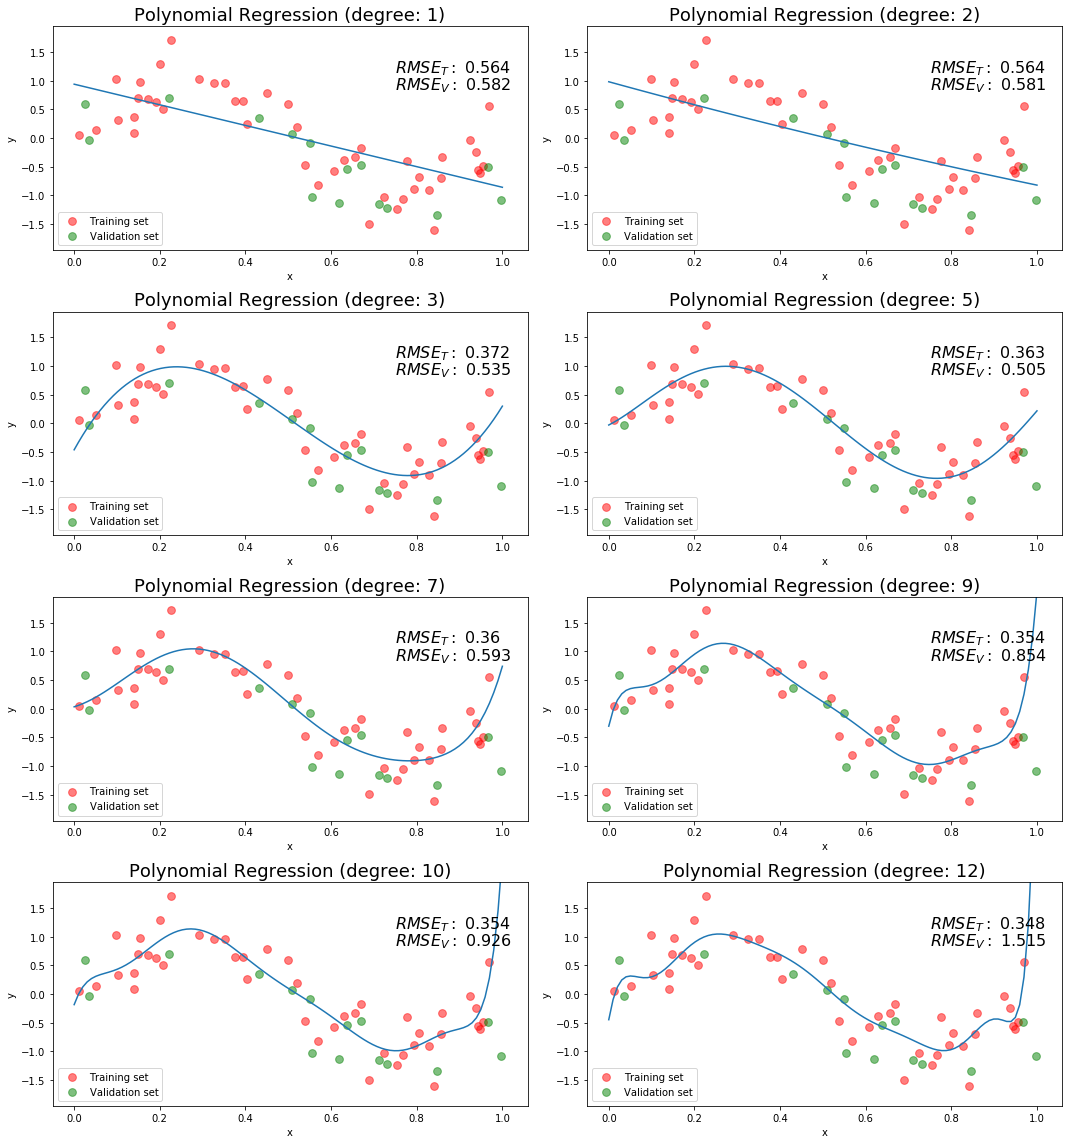

In [17]:
fix, axes = plt.subplots(4,2,figsize=(15,16))
axes = axes.ravel()
rmse_train_metric = []
rmse_val_metric = []
degrees = [1,2,3,5,7,9,10,12]
for e, degree in enumerate(degrees):
    (rmse_train, 
     rmse_val, 
     y_predict_reg_line) = build_polynomial_model(X_train,
                                                  y_train,
                                                  X_val,
                                                  y_val,
                                                  degree=degree)
    rmse_train_metric.append(rmse_train)
    rmse_val_metric.append(rmse_val)
    
    
    
    visualize_polynomial_model(train=train, val=val, 
                               x_regline=np.linspace(0,1, 100),
                               y_regline=y_predict_reg_line,
                               rmse_train=rmse_train, rmse_val=rmse_val,
                               degree=degree, ax=axes[e])
plt.tight_layout()

Awesome, pretty plots! The figure shows, that if we increase $k$, the order of the polynomial, the curve becomes more flexible and it fits the data better and better. The better the data is fitted the lower becomes the error, RMSE. 

What is the best polynomial to fit the data?   

Recall the goal is to learn the parameters from the data, thus we are interested in achieving a good generalization of the model and not necessarily perfectly fitted observation data. Such a behavior is known as [**over-fitting**](https://en.wikipedia.org/wiki/Overfitting).


For convenience we plot the RMSE against $k$. 

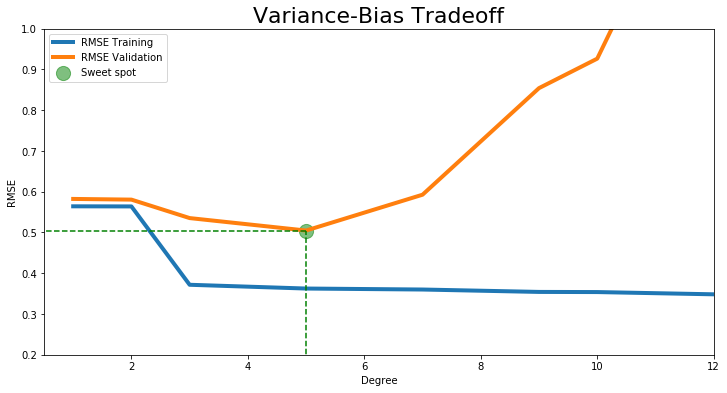

In [28]:
# build data frame
res = pd.DataFrame({"RMSE Training":rmse_train_metric,
                    "RMSE Validation":rmse_val_metric},
                    index=degrees)
# compute sweet spot
sweet_spot_y = res["RMSE Validation"].min()
sweet_spot_x = res["RMSE Validation"].idxmin()

# plot
fig, ax = plt.subplots(figsize=(12,6))
res.plot(ax=ax, linewidth=4)
ax.scatter(x=sweet_spot_x, y=sweet_spot_y, s=200, 
           alpha=0.5, label="Sweet spot", color="g")
ax.plot((sweet_spot_x, sweet_spot_x),(0,sweet_spot_y),
        linestyle="dashed", color="g")
ax.plot((sweet_spot_x, sweet_spot_y),(sweet_spot_y, sweet_spot_y),
        linestyle="dashed", color="g")

ax.set_ylim(0.2,1)
ax.set_xlim(0.5,12)
ax.set_xlabel("Degree")
ax.set_ylabel("RMSE")
ax.legend()
ax.set_title("Variance-Bias Tradeoff", size=22);

The figure shows that the error on the training data (blue line) is constantly decreasing. If we take a look at the RMSE for the validation set (orange line), we see that with increasing $k$, and thus increasing model complexity, the error decreases.

Note that there is a sweet spot, indicated by the lowest RMSE on the validation set, where the model is just complex enough to generalize well on the so far unseen validation data. In our example the sweet spot is obtained for a regression model of 5<sup>th</sup> order. 